In [1]:
# <!-- collapse=True -->
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=18)

#params = {'legend.fontsize': 'x-large',
#          'figure.figsize': (15, 5),
#         'axes.labelsize': 'x-large',
#         'axes.titlesize':'x-large',
#         'xtick.labelsize':'x-large',
#         'ytick.labelsize':'x-large'}
#pylab.rcParams.update(params)

# Shape from focus

La profondeur de champ d'un microscope peut être assez faible, limitant la possibilité d'observer un objet en 3d. En revanche le réglage du focus en souvent très fin, et permet de scanner verticalement l'objet, ceci de façon mécanique. L'idée est donc de prendre une série de photo correspondant à des hauteur différentes pour ensuite les combiner numériquement et ainsi augmenter la profondeur de champ de l'image finale.


C'est une technique existante et déjà étudiée. Il existe plusieurs articles concernant ce sujet.



J'ai voulu tester cette idée sur une fleur, étant donné qu'il est plus difficile d'attraper une fourmi.

Avec un peu de patience on obtient un cube d'une vingtaine d'images correspondant à différente coupe de l'objet. Je n'ai pas trouver l'information sur le déplacement "en z" du focus...


La question est de comment évaluer numériquement les zones floues ou nette à l'intérieur de chaque image, afin constituer une image finale entièrement nette.

On utilise la librairie `ndimage` de Scipy ([doc](https://docs.scipy.org/doc/scipy-0.18.1/reference/ndimage.html)).

In [2]:
from scipy import ndimage

## Chargement des photos

In [87]:
n = 20 # nombre de photos

images = []
for i in range(1, n+1):
    filename = './data_shapefromfocus/'+'focus%02d.jpg'%i
    images.append( ndimage.imread(filename) ) #, flatten=True

Exemples de 5 images:

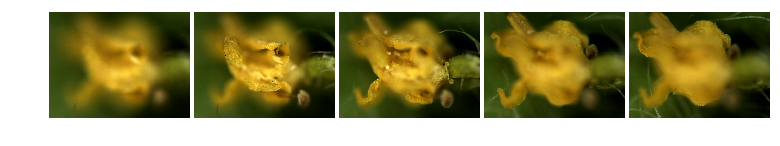

In [88]:
# <!-- collapse=True -->
fig, ax = plt.subplots( 1, 5 , figsize=(10, 6));
for i in range(5):
    k = i*3
    ax[i].imshow( images[k] )
    ax[i].set_adjustable('box')
    ax[i].axis('off')#_off()
    
plt.subplots_adjust(wspace=0.03, hspace=.02 , top=1, bottom=0, left=0, right=1);

On travail sur les valeurs de gris seulement. La fonction suivante permet de convertir les valeurs RGB en scalaire.

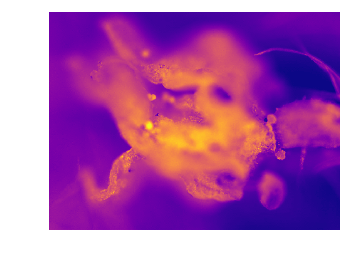

In [86]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
plt.imshow( rgb2gray( images[6] ), cmap=plt.cm.plasma);
plt.axis('off');

On souhaite valuer le degrée de flou ou de netteté de chaque pixels. Pour cela l'idée est de calculer la dérivée seconde (le Laplacien) en chaque point des images. Le filtre `gaussian_laplace(I, sigma)` permet de réaliser cela ([doc](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.ndimage.gaussian_laplace.html#scipy.ndimage.gaussian_laplace)).

In [119]:
laplaciens = []
for I in images:
    Igray = rgb2gray( I )
    curv = ndimage.filters.gaussian_laplace( Igray , 3)
    laplaciens.append( curv**2  )

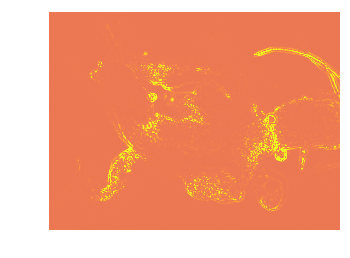

In [120]:
plt.imshow(  laplaciens[6] , cmap=plt.cm.plasma, vmin=-2, vmax=1 );
plt.axis('off');

Profil transverse

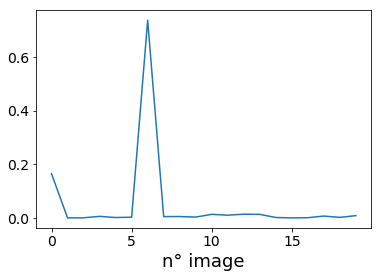

In [121]:
pixel = (500, 550)
profil = [ L[pixel] for L in laplaciens]

plt.plot( profil ); plt.xlabel('n° image');

on cherche ensuite l'argument (l'indice) du maximum pour chaque pixel

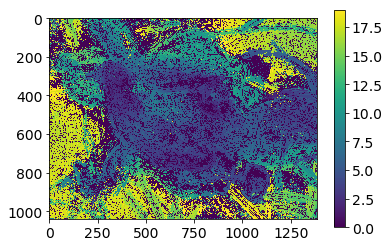

In [122]:
cArgMax = np.argmax(  np.array(laplaciens), 0 )

plt.figure()
plt.imshow(cArgMax)
plt.colorbar()
plt.show()

On filtre par la medianne

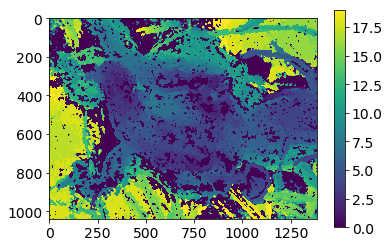

In [123]:
cMax = ndimage.filters.median_filter(cArgMax, footprint=np.ones((10,10)) )
cMax = np.round( cMax )

plt.figure()
plt.imshow(cMax)
plt.colorbar()
plt.show()

puis on forme une image unique en choisiant le pixel le plus nette dans chaque image

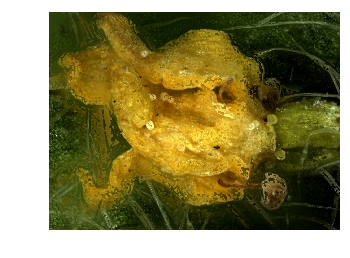

In [124]:
I_merged = images[0]
for k, I in enumerate( images ):
    I_merged[ cMax==k ] = images[k][ cMax==k ]

plt.imshow( I_merged );
plt.axis('off');

Le **microscope électronique à balayage** est quand même beaucoup mieux pour faire des photos de fourmis: https://commons.wikimedia.org/wiki/File:Ant_with_gear.jpg